In [1]:
import mxnet as mx
print(mx.__version__)

1.0.0


/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
mx.random.seed(1)
#ctx = mx.gpu(0)
ctx = mx.cpu(0)

import aifc # ReadAIFF

import math
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from matplotlib import mlab
# import matplotlib

%matplotlib inline




## 1. DATASET

#### Load Data

In [3]:
# Set path to directory with folders train and test
path_data = './data/'

In [4]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()



In [5]:
# AIFF Data
s = ReadAIFF(path_data + 'train/train6.aiff')
pd.DataFrame(s).T

# 결과: 2000Hz의 2초 사운드 클립마다 프레임의 채널에서 압축되지 않은 샘플의 4000개 진폭값

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,42,-486,-22,190,-102,-36,0,-45,-194,194,...,-221,-99,523,185,-414,-324,203,219,-155,-32


In [6]:
# Label Data
!head ./data/train.csv

clip_name,label
train1.aiff,0
train2.aiff,0
train3.aiff,0
train4.aiff,0
train5.aiff,0
train6.aiff,1
train7.aiff,1
train8.aiff,0
train9.aiff,1


In [7]:
import csv
import random

train_label = []
train_audio = []

valid_label = []
valid_audio = []

valid_frac = 0.3

f = open(path_data + 'train.csv', 'r')
rdr = csv.reader(f)
skip_header = next(rdr)
for line in rdr:
    s = ReadAIFF(path_data + 'train/' + line[0])
    if random.random() > valid_frac:
        train_label.append(line[1])
        train_audio.append(list(s))
    else:
        valid_label.append(line[1])
        valid_audio.append(list(s))

f.close()

In [8]:
train_label = mx.nd.array(train_label)
train_audio = mx.nd.array(train_audio)
valid_label = mx.nd.array(valid_label)
valid_audio = mx.nd.array(valid_audio)

In [9]:
print("train_label.shape", train_label.shape)
print("train_audio.shape", train_audio.shape)
print("valid_label.shape", valid_label.shape)
print("valid_audio.shape", valid_audio.shape)

train_label.shape (20893,)
train_audio.shape (20893, 4000)
valid_label.shape (9107,)
valid_audio.shape (9107, 4000)


#### Normalize Function

In [10]:
def norm_zscore(data, norm_axis=None):
    if norm_axis==None:
        mean = nd.mean(data)
        sd = nd.sqrt(nd.mean(nd.power(data,2)) - nd.power(nd.mean(data),2))
        return (data - mean) / sd
    elif norm_axis==0:
        mean = nd.mean(data, axis=norm_axis)
        sd = nd.sqrt(nd.mean(nd.power(data,2), axis=norm_axis) - nd.power(nd.mean(data, axis=norm_axis),2))
        return (data - mean) / sd
    elif norm_axis==1:
        mean = nd.mean(data, axis=norm_axis)
        sd = nd.sqrt(nd.mean(nd.power(data,2), axis=norm_axis) - nd.power(nd.mean(data, axis=norm_axis),2))
        return (data - mean.reshape((-1,1))) / sd.reshape((-1,1))
    else:
        raise ValueError("Invalid norm_axis %s. norm_axis are (None, 0, 1)" % norm_axis)


def norm_minmax(data, norm_axis=None):
    if norm_axis==None:
        return (data - nd.min(data)) / (nd.max(data) - nd.min(data))
    elif norm_axis==0:
        return (data - nd.min(data, axis=norm_axis)) / (nd.max(data, axis=norm_axis) - nd.min(data, axis=norm_axis))
    elif norm_axis==1:
        return (data - nd.min(data, axis=norm_axis).reshape((-1,1))) / (nd.max(data, axis=norm_axis) - nd.min(data, axis=norm_axis)).reshape((-1,1))
    else:
        raise ValueError("Invalid norm_axis %s. norm_axis are (None, 0, 1)" % norm_axis)



In [11]:
def plot_audiodata(data, index):
    print('RAW')
    plt.plot(data[index].asnumpy());
    plt.show()

    print('norm_zscore - 전체 / axis=0(시간대별) / axis=1(레코드별)')
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1 = plt.plot(norm_zscore(data)[index].asnumpy());
    ax2 = fig.add_subplot(132)
    ax2 = plt.plot(norm_zscore(data, norm_axis=0)[index].asnumpy());
    ax3 = fig.add_subplot(133)
    ax3 = plt.plot(norm_zscore(data, norm_axis=1)[index].asnumpy());
    plt.tight_layout()
    plt.show()

    print('norm_minmax - 전체 / axis=0(시간대별) / axis=1(레코드별)')
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1 = plt.plot(norm_minmax(data)[index].asnumpy());
    ax2 = fig.add_subplot(132)
    ax2 = plt.plot(norm_minmax(data, norm_axis=0)[index].asnumpy());
    ax3 = fig.add_subplot(133)
    ax3 = plt.plot(norm_minmax(data, norm_axis=1)[index].asnumpy());
    plt.tight_layout()
    plt.show()

RAW


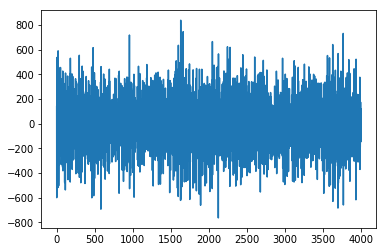

norm_zscore - 전체 / axis=0(시간대별) / axis=1(레코드별)


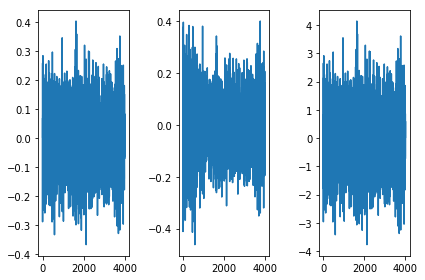

norm_minmax - 전체 / axis=0(시간대별) / axis=1(레코드별)


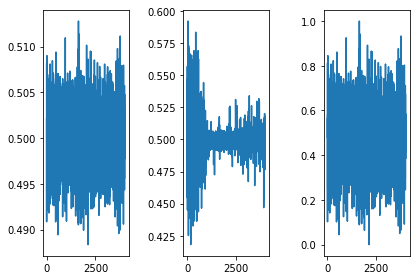

In [12]:
plot_audiodata(train_audio, 3)

In [13]:
def one_hot_encode(label):
    n_label = len(label)
    n_unique_label = len(np.unique(label.asnumpy()))
    res = nd.zeros((n_label, n_unique_label), ctx=ctx)
    res[nd.arange(n_label), label] = 1.0
    return res

In [14]:
train_label_onehot = one_hot_encode(train_label)
print('Shape of train_label_onehot: ', train_label_onehot.shape) #(num_samples, output_dims)

valid_label_onehot = one_hot_encode(valid_label)
print('Shape of valid_label_onehot: ', valid_label_onehot.shape) #(num_samples, output_dims)



Shape of train_label_onehot:  (20893, 2)
Shape of valid_label_onehot:  (9107, 2)


## 2. PreProcessing

In [15]:
batch_size = 32

#### Feature Data

In [16]:
seq_length = train_audio.shape[1]
dims = 1 # input_dims, channels

print('Shape of train_audio: ', train_audio.shape) #(num_samples, seq_length)
print('# of sequences in train_audio: ', len(train_audio))

train_audio_batch = train_audio.reshape((-1, seq_length, dims))
print('Shape of train_audio_batch: ', train_audio_batch.shape) #(num_samples, seq_length, input_dims)

num_batches = len(train_audio_batch) // batch_size
print('Size of batch: ', batch_size)
print('# of batches: ', num_batches)

train_audio_batch = train_audio_batch[:num_batches*batch_size]
print('Shape of train_audio_batch: ', train_audio_batch.shape) #(num_batches*batch_size, seq_length, input_dims)
train_audio_batch = train_audio_batch.reshape((batch_size, num_batches, seq_length, dims))
print('Shape of train_audio_batch: ', train_audio_batch.shape) #(batch_size, num_batches, seq_length, input_dims)

# swap batch_size and seq_length axis to make later access easier
train_audio_batch = nd.swapaxes(train_audio_batch, 0, 1)
print('Shape of train_audio_batch: ', train_audio_batch.shape) #(num_batches, batch_size, seq_length, input_dims)
train_audio_batch = nd.swapaxes(train_audio_batch, 1, 2)
print('Shape of train_audio_batch: ', train_audio_batch.shape) #(num_batches, seq_length, batch_size, input_dims)

Shape of train_audio:  (20893, 4000)
# of sequences in train_audio:  20893
Shape of train_audio_batch:  (20893, 4000, 1)
Size of batch:  32
# of batches:  652
Shape of train_audio_batch:  (20864, 4000, 1)
Shape of train_audio_batch:  (32, 652, 4000, 1)
Shape of train_audio_batch:  (652, 32, 4000, 1)
Shape of train_audio_batch:  (652, 4000, 32, 1)


##### Sanity Check

In [17]:
for i in range(3):
    print("***First Record in Batch %s:***\n\n%s\n\n%s\n\n" % (i, train_audio[i], train_audio_batch[i,:,0]))

***First Record in Batch 0:***


[-197.  231.   79. ..., -303.   41.  120.]
<NDArray 4000 @cpu(0)>


[[-197.]
 [ 231.]
 [  79.]
 ..., 
 [-303.]
 [  41.]
 [ 120.]]
<NDArray 4000x1 @cpu(0)>


***First Record in Batch 1:***


[ 292. -258.   44. ...,  155. -512. -300.]
<NDArray 4000 @cpu(0)>


[[ 292.]
 [-258.]
 [  44.]
 ..., 
 [ 155.]
 [-512.]
 [-300.]]
<NDArray 4000x1 @cpu(0)>


***First Record in Batch 2:***


[ -56.  -12.   -9. ...,  160.   19. -231.]
<NDArray 4000 @cpu(0)>


[[ -56.]
 [ -12.]
 [  -9.]
 ..., 
 [ 160.]
 [  19.]
 [-231.]]
<NDArray 4000x1 @cpu(0)>




#### Label Data

In [18]:
# Preparing the data for training 과 동일한 방법
# (num_samples, output_dims)
# --> num_samples를 num_batches*batch_size 길이로 고정
# --> (batch_size, num_batches, seq_length, output_dims)
# --> (num_batches, seq_length, batch_size, output_dims)

print('Shape of train_label_onehot: ', train_label_onehot.shape) #(num_samples, output_dims)

seq_length = 1
dims = train_label_onehot.shape[1] # output_dims

train_label_batch_1 = train_label_onehot.reshape((-1, seq_length, dims))
print('Shape of train_label_batch_1: ', train_label_batch_1.shape) #(num_samples, seq_length, output_dims)

train_label_batch_1 = train_label_batch_1[:num_batches*batch_size]
print('Shape of train_label_batch_1: ', train_label_batch_1.shape) #(num_batches*batch_size, output_dims)

train_label_batch_1 = train_label_batch_1.reshape((batch_size, num_batches, seq_length, dims))
print('Shape of train_label_batch_1: ', train_label_batch_1.shape) #(batch_size, num_batches, seq_length, output_dims)
train_label_batch_1 = nd.swapaxes(train_label_batch_1, 0, 1)
print('Shape of train_label_batch_1: ', train_label_batch_1.shape) #(num_batches, batch_size, seq_length, output_dims)
train_label_batch_1 = nd.swapaxes(train_label_batch_1, 1, 2)
print('Shape of train_label_batch_1: ', train_label_batch_1.shape) #(num_batches, seq_length, batch_size, output_dims)




Shape of train_label_onehot:  (20893, 2)
Shape of train_label_batch_1:  (20893, 1, 2)
Shape of train_label_batch_1:  (20864, 1, 2)
Shape of train_label_batch_1:  (32, 652, 1, 2)
Shape of train_label_batch_1:  (652, 32, 1, 2)
Shape of train_label_batch_1:  (652, 1, 32, 2)


In [19]:
print('Shape of train_label_onehot: ', train_label_onehot.shape) #(num_samples, output_dims)

seq_length = 1
dims = train_label_onehot.shape[1] # output_dims

train_label_batch_2 = train_label_onehot.reshape((-1, seq_length, dims))
print('Shape of train_label_batch_2: ', train_label_batch_2.shape) #(num_samples, seq_length, output_dims)

train_label_batch_2 = train_label_batch_2.reshape((batch_size, num_batches, seq_length, dims))
print('Shape of train_label_batch_2: ', train_label_batch_2.shape) #(batch_size, num_batches, seq_length, output_dims)
train_label_batch_2 = nd.swapaxes(train_label_batch_2, 0, 1)
print('Shape of train_label_batch_2: ', train_label_batch_2.shape) #(num_batches, batch_size, seq_length, output_dims)
train_label_batch_2 = nd.swapaxes(train_label_batch_2, 1, 2)
print('Shape of train_label_batch_2: ', train_label_batch_2.shape) #(num_batches, seq_length, batch_size, output_dims)


Shape of train_label_onehot:  (20893, 2)
Shape of train_label_batch_2:  (20893, 1, 2)
Shape of train_label_batch_2:  (32, 652, 1, 2)
Shape of train_label_batch_2:  (652, 32, 1, 2)
Shape of train_label_batch_2:  (652, 1, 32, 2)


In [20]:
np.array_equal(train_label_batch_1.asnumpy(), train_label_batch_2.asnumpy())

True

##### Sanity Check

In [21]:
for i in range(5):
    print("***First Record in Batch %s:***\n\n%s : %s\n\n" % (i, train_label[i].asnumpy(), train_label_batch_1[i,:,0].asnumpy()))

***First Record in Batch 0:***

[ 0.] : [[ 1.  0.]]


***First Record in Batch 1:***

[ 0.] : [[ 1.  0.]]


***First Record in Batch 2:***

[ 0.] : [[ 1.  0.]]


***First Record in Batch 3:***

[ 1.] : [[ 0.  1.]]


***First Record in Batch 4:***

[ 0.] : [[ 1.  0.]]




In [22]:
# (참고) mx.nd.array는 전체 길이가 다른 Shape으로 변경 가능

print('\nnp.array: Size 150 into (2,3,4,5)\n')
try:
    print(np.array(range(150)).reshape((2,3,4,5)))
except ValueError:
    print('np.array: Cannot reshape array into different shape')

print('\nmx.nd.array: Size 150 into (2,3,4,5)\n')
try:
    print(print(mx.nd.array(range(150)).reshape((2,3,4,5))))
except ValueError:
    print('mx.nd.array: Cannot reshape array into different shape')
    




np.array: Size 150 into (2,3,4,5)

np.array: Cannot reshape array into different shape

mx.nd.array: Size 150 into (2,3,4,5)


[[[[   0.    1.    2.    3.    4.]
   [   5.    6.    7.    8.    9.]
   [  10.   11.   12.   13.   14.]
   [  15.   16.   17.   18.   19.]]

  [[  20.   21.   22.   23.   24.]
   [  25.   26.   27.   28.   29.]
   [  30.   31.   32.   33.   34.]
   [  35.   36.   37.   38.   39.]]

  [[  40.   41.   42.   43.   44.]
   [  45.   46.   47.   48.   49.]
   [  50.   51.   52.   53.   54.]
   [  55.   56.   57.   58.   59.]]]


 [[[  60.   61.   62.   63.   64.]
   [  65.   66.   67.   68.   69.]
   [  70.   71.   72.   73.   74.]
   [  75.   76.   77.   78.   79.]]

  [[  80.   81.   82.   83.   84.]
   [  85.   86.   87.   88.   89.]
   [  90.   91.   92.   93.   94.]
   [  95.   96.   97.   98.   99.]]

  [[ 100.  101.  102.  103.  104.]
   [ 105.  106.  107.  108.  109.]
   [ 110.  111.  112.  113.  114.]
   [ 115.  116.  117.  118.  119.]]]]
<NDArray 2x3x4x5 

In [23]:
def generate_batch_data(data, seq_length, dims, batch_size, normalize=None, **kwargs):
    
    data = mx.nd.array(data)
    
    if normalize!=None:
        data = normalize(data, **kwargs)
        
    data = data.reshape((-1, seq_length, dims))
    
    num_batches = len(data) // batch_size    
    
    data_batch = data.reshape((batch_size, num_batches, seq_length, dims))
    data_batch = nd.swapaxes(data_batch, 0, 1)
    data_batch = nd.swapaxes(data_batch, 1, 2)
    return data_batch





In [24]:
train_x = generate_batch_data(data = train_audio,
                              seq_length = train_audio.shape[1],
                              dims = 1, # 1 Channel (Monophonic)
                              batch_size = batch_size,
                              normalize = norm_zscore,
                              norm_axis = 1
                             )

valid_x = generate_batch_data(data = valid_audio,
                              seq_length = valid_audio.shape[1],
                              dims = 1, # 1 Channel (Monophonic)
                              batch_size = batch_size,
                              normalize = norm_zscore,
                              norm_axis = 1
                             )

train_y = generate_batch_data(data = train_label_onehot,
                              seq_length = 1, # last output
                              dims = train_label_onehot.shape[1],
                              batch_size = batch_size
                             )

valid_y = generate_batch_data(data = valid_label_onehot,
                              seq_length = 1, # last output
                              dims = valid_label_onehot.shape[1],
                              batch_size = batch_size
                             )

In [25]:
# print(np.array_equal(train_audio_batch.asnumpy(), train_x.asnumpy()))
# print(np.array_equal(train_label_batch_1.asnumpy(), train_y.asnumpy()))

## 3. Define Activation, Loss, Optimizer

#### Activation

In [26]:
def sigmoid(x):
    return 1. / (1. + nd.exp(-x))
# Same as nd.Activation(x, act_type='sigmoid')

def tanh(x):
    return (nd.exp(x) - nd.exp(-x)) / (nd.exp(x) + nd.exp(-x))
# Same as nd.Activation(x, act_type='tanh')

def softmax(y_linear, temperature=1.0):
    lin = (y_linear-nd.max(y_linear, axis=1).reshape((-1,1))) / temperature # shift each row of y_linear by its max
    exp = nd.exp(lin)
    partition =nd.sum(exp, axis=1).reshape((-1,1))
    return exp / partition

#### Loss

In [27]:
# def cross_entropy(yhat, y):
#     return - nd.sum(y * nd.log(yhat))

def cross_entropy(yhat, y):
    return - nd.mean(nd.sum(y * nd.log(yhat), axis=0, exclude=True))

# Define accuracy metric
def accuracy(yhat, y):
    pred = nd.argmax(yhat, axis = 1)
    real = nd.argmax(y, axis = 1)
    correct = nd.sum(pred == real)
    total = yhat.shape[0]
    return correct / total

In [28]:
cross_entropy(nd.array([[.2,.8], [.2,.8]]), nd.array([[1.,0], [0, 1.]]))


[ 0.91629076]
<NDArray 1 @cpu(0)>

In [29]:
accuracy(nd.array([[.2,.8], [.2,.8]]), nd.array([[1.,0], [0, 1.]]))


[ 0.5]
<NDArray 1 @cpu(0)>

#### Averaging the loss over the sequence
##### (Many-to-Many의 Output일 경우)

In [30]:
def average_ce_loss(outputs, labels):
    assert(len(outputs) == len(labels))
    total_loss = 0.
    for (output, label) in zip(outputs,labels):
        total_loss = total_loss + cross_entropy(output, label)
    return total_loss / len(outputs)

def average_acc(outputs, labels):
    assert(len(outputs) == len(labels))
    total_acc = 0.
    for (output, label) in zip(outputs,labels):
        total_acc = total_acc + accuracy(output, label)
    return total_acc / len(outputs)

#### Optimizer

In [31]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## 4. Model

In [32]:
class RNNModel_layer1():

    def __init__(self, model, train, valid, hidden_dims, ctx):
        assert(train[0].shape[1:] == valid[0].shape[1:])
        assert(train[1].shape[1:] == valid[1].shape[1:])
        
        self.model = model
        self.train_x = train[0]
        self.train_y = train[1]
        self.valid_x = valid[0]
        self.valid_y = valid[1]
        self.num_batches = self.train_x.shape[0]
        self.input_dims = self.train_x.shape[3]
        self.output_dims = self.train_y.shape[3]
        self.hidden_dims = hidden_dims
        self.seq_outputs = self.train_y.shape[1]
        self.ctx = ctx
                
        
    def allocate_params(self):        
        if self.model == 'simple_rnn':
            ########################
            #  Weights connecting the inputs to the hidden layer
            ########################
            self.Wxh = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01

            ########################
            #  Recurrent weights connecting the hidden layer across time steps
            ########################
            self.Whh = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx) * .01

            ########################
            #  Bias vector for hidden layer
            ########################
            self.bh = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01

            ########################
            # Weights to the output nodes
            ########################
            self.Why = nd.random_normal(shape=(self.hidden_dims, self.output_dims), ctx=self.ctx) * .01
            self.by = nd.random_normal(shape=self.output_dims, ctx=self.ctx) * .01

            # NOTE: to keep notation consistent,
            # we should really use capital letters
            # for hidden layers and outputs,
            # since we are doing batchwise computations]

            ########################
            # Attach the gradients
            ########################
            self.params = [self.Wxh, self.Whh, self.bh, self.Why, self.by]
            for self.param in self.params:
                self.param.attach_grad()
        
        
        elif self.model == 'lstm':
            ########################
            #  Weights connecting the inputs to the hidden layer
            ########################
            self.Wxg = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01
            self.Wxi = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01
            self.Wxf = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01
            self.Wxo = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01

            ########################
            #  Recurrent weights connecting the hidden layer across time steps
            ########################
            self.Whg = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx)* .01
            self.Whi = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx)* .01
            self.Whf = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx)* .01
            self.Who = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx)* .01

            ########################
            #  Bias vector for hidden layer
            ########################
            self.bg = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01
            self.bi = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01
            self.bf = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01
            self.bo = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01

            ########################
            # Weights to the output nodes
            ########################
            self.Why = nd.random_normal(shape=(self.hidden_dims, self.output_dims), ctx=self.ctx) * .01
            self.by = nd.random_normal(shape=self.output_dims, ctx=self.ctx) * .01

            ########################
            # Attach the gradients
            ########################
            self.params = [self.Wxg, self.Wxi, self.Wxf, self.Wxo]
            self.params = self.params + [self.Whg, self.Whi, self.Whf, self.Who]
            self.params = self.params + [self.bg, self.bi, self.bf, self.bo]
            self.params = self.params + [self.Why, self.by]
            for self.param in self.params:
                self.param.attach_grad()

        elif self.model == 'gru':
            ########################
            #  Weights connecting the inputs to the hidden layer
            ########################
            self.Wxz = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01
            self.Wxr = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01
            self.Wxh = nd.random_normal(shape=(self.input_dims, self.hidden_dims), ctx=self.ctx) * .01

            ########################
            #  Recurrent weights connecting the hidden layer across time steps
            ########################
            self.Whz = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx)* .01
            self.Whr = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx)* .01
            self.Whh = nd.random_normal(shape=(self.hidden_dims, self.hidden_dims), ctx=self.ctx)* .01

            ########################
            #  Bias vector for hidden layer
            ########################
            self.bz = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01
            self.br = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01
            self.bh = nd.random_normal(shape=self.hidden_dims, ctx=self.ctx) * .01

            ########################
            # Weights to the output nodes
            ########################
            self.Why = nd.random_normal(shape=(self.hidden_dims, self.output_dims), ctx=self.ctx) * .01
            self.by = nd.random_normal(shape=self.output_dims, ctx=self.ctx) * .01
            
            ########################
            # Attach the gradients
            ########################
            self.params = [self.Wxz, self.Wxr, self.Wxh]
            self.params = self.params + [self.Whz, self.Whr, self.Whh]
            self.params = self.params + [self.bz, self.br, self.bh]
            self.params = self.params + [self.Why, self.by]
            for self.param in self.params:
                self.param.attach_grad()
        
        else:
            raise ValueError("Invalid mode %s. Options are simple_rnn, lstm, and gru" % self.mode)
    
    def SGD(self, lr):
        for self.param in self.params:
            self.param[:] = self.param - lr * self.param.grad
    
    def rnn_model(self, inputs, h, c=None, mode='train', **kwargs):
        outputs = []
        for X in inputs:
            if self.model == 'simple_rnn':
                h_linear = nd.dot(X, self.Wxh) + nd.dot(h, self.Whh) + self.bh
                h = nd.tanh(h_linear)
                
            elif self.model == 'lstm':
                g = nd.tanh(nd.dot(X, self.Wxg) + nd.dot(h, self.Whg) + self.bg)
                i = nd.sigmoid(nd.dot(X, self.Wxi) + nd.dot(h, self.Whi) + self.bi)
                f = nd.sigmoid(nd.dot(X, self.Wxf) + nd.dot(h, self.Whf) + self.bf)
                o = nd.sigmoid(nd.dot(X, self.Wxo) + nd.dot(h, self.Who) + self.bo)

                c = f * c + i * g
                h = o * nd.tanh(c)
            elif self.model == 'gru':
                z = nd.sigmoid(nd.dot(X, self.Wxz) + nd.dot(h, self.Whz) + self.bz)
                r = nd.sigmoid(nd.dot(X, self.Wxr) + nd.dot(h, self.Whr) + self.br)
                g = nd.tanh(nd.dot(X, Wxh) + nd.dot(r * h, self.Whh) + self.bh)
                
                h = z * h + (1 - z) * g
                
            yhat_linear = nd.dot(h, self.Why) + self.by
                            
            if(self.output_dims == 2):
                yhat = sigmoid(yhat_linear)
            elif(self.output_dims > 2):
                yhat = softmax(yhat_linear, **kwargs)                
            outputs.append(yhat)
        
        if self.seq_outputs == 1:
            outputs = outputs[len(outputs)-1]
            
        if self.model in ['simple_rnn', 'gru']:
            return (outputs, h)
        elif self.model == 'lstm':
            return (outputs, h, c)

        
    def set_sample_generation(self, prefix, num_chars, temperature=1.0):
        self.prefix = prefix
        self.num_chars = num_chars
        self.temperature = temperature
        
    def run_sample_generation(self):
        #####################################
        # Initialize the string that we'll return to the supplied prefix
        #####################################
        string = self.prefix

        #####################################
        # Prepare the prefix as a sequence of one-hots for ingestion by RNN
        #####################################
        prefix_numerical = [character_dict[char] for char in self.prefix]
        input = one_hots(prefix_numerical)

        #####################################
        # Set the initial state of the hidden representation ($h_0$) to the zero vector
        #####################################
        h = nd.zeros(shape=(1, self.hidden_dims), ctx=self.ctx)
        if self.model == 'lstm':
            c = nd.zeros(shape=(1, self.hidden_dims), ctx=self.ctx)



        #####################################
        # For num_chars iterations,
        #     1) feed in the current input
        #     2) sample next character from from output distribution
        #     3) add sampled character to the decoded string
        #     4) prepare the sampled character as a one_hot (to be the next input)
        #####################################
        for i in range(self.num_chars):
            if self.model in ['simple_rnn', 'gru']:
                outputs, h = self.rnn_model(input, h, temperature=.1)
            elif self.model == 'lstm':
                outputs, h, c = self.rnn_model(input, h, c, temperature=.1)

            #outputs, h = self.simple_rnn(input, h, temperature=.1)
            
            choice = np.random.choice(vocab_size, p=outputs[-1][0].asnumpy())
            string += character_list[choice]
            input = one_hots([choice])
        return string

    def run(self, epochs, learning_rate):
        for e in range(epochs):
            ############################
            # Attenuate the learning rate by a factor of 2 every 100 epochs.
            ############################
            if ((e+1) % 10 == 0):
                learning_rate = learning_rate / 2.0
            
            h = nd.zeros(shape=(batch_size, self.hidden_dims), ctx=ctx)
            if self.model == 'lstm':
                c = nd.zeros(shape=(batch_size, self.hidden_dims), ctx=ctx)
            
            if self.seq_outputs == 1:
                loss_func = cross_entropy
                acc_func = accuracy
                if e==0:
                    self.train_y = self.train_y[:,0]
                    self.valid_y = self.valid_y[:,0]
                
            elif self.seq_outputs > 1:
                loss_func = average_ce_loss
                acc_func = average_acc

            for i in range(self.num_batches):
                with autograd.record():
                    if self.model in ['simple_rnn', 'gru']:
                        outputs, h = self.rnn_model(self.train_x[i], h, mode='train')
                    elif self.model == 'lstm':
                        outputs, h, c = self.rnn_model(self.train_x[i], h, c, mode='train')

                    loss = loss_func(outputs, self.train_y[i])
                    loss.backward()
                self.SGD(learning_rate)
                
                k = random.sample(range(len(valid_x)), 1)[0]
                if self.model in ['simple_rnn', 'gru']:
                    val_outputs, _ = self.rnn_model(self.valid_x[k], h, mode='valid')
                elif self.model == 'lstm':
                    val_outputs, _, _ = self.rnn_model(self.valid_x[k], h, c, mode='valid')
                
                val_loss = loss_func(val_outputs, self.valid_y[k])
                val_acc = acc_func(val_outputs, self.valid_y[k])
                
                ##########################
                #  Keep a moving average of the losses
                ##########################
                tr_loss = round(loss.asnumpy()[0], 3)
                val_loss = round(val_loss.asnumpy()[0], 3)
                val_acc = round(val_acc.asnumpy()[0], 3)

                if (i == 0) and (e == 0):
                    tr_moving_loss = round(np.mean(tr_loss) ,3)
                    val_moving_loss = round(np.mean(val_loss), 3)
                    val_moving_acc = round(np.mean(val_acc) ,3)
                else:
                    tr_moving_loss = round(.9 * tr_moving_loss + .1 * np.mean(tr_loss) ,3)
                    val_moving_loss = round(.9 * val_moving_loss + .1 * np.mean(tr_loss) ,3)
                    val_moving_acc = round(.9 * val_moving_acc + .1 * np.mean(val_acc) ,3)
                
                if i % 100 == 0:
                    print("Epoch %s. Batch %s. Loss: %s. Moving Loss: %s. Val Loss: %s. Val Moving Loss: %s. Val Acc: %s. Val Moving Acc: %s." %
                          (e, i, tr_loss, tr_moving_loss, val_loss, val_moving_loss, val_acc, val_moving_acc))
            
            print("Epoch %s. Loss: %s. Val Loss: %s. Val ACC: %s" % (e, tr_moving_loss, val_moving_loss, val_moving_acc))
            if 'prefix' in dir(self):
                print(self.run_sample_generation())
                
            print('**************** End of Epoch %s ****************' % (e))




In [33]:
trainset = [train_x, train_y]
validset = [valid_x, valid_y]

In [34]:

RNN = RNNModel_layer1(model = 'simple_rnn', train = trainset, valid = validset, hidden_dims = 10, ctx=ctx)
RNN.allocate_params()
RNN.run(epochs = 1, learning_rate = .05)


Epoch 0. Batch 0. Loss: 0.695. Moving Loss: 0.695. Val Loss: 0.686. Val Moving Loss: 0.686. Val Acc: 0.781. Val Moving Acc: 0.781.
Epoch 0. Batch 100. Loss: 0.287. Moving Loss: 0.316. Val Loss: 0.292. Val Moving Loss: 0.316. Val Acc: 0.781. Val Moving Acc: 0.769.
Epoch 0. Batch 200. Loss: 0.171. Moving Loss: 0.181. Val Loss: 0.17. Val Moving Loss: 0.181. Val Acc: 0.812. Val Moving Acc: 0.767.
Epoch 0. Batch 300. Loss: 0.122. Moving Loss: 0.122. Val Loss: 0.121. Val Moving Loss: 0.122. Val Acc: 0.781. Val Moving Acc: 0.741.
Epoch 0. Batch 400. Loss: 0.082. Moving Loss: 0.087. Val Loss: 0.077. Val Moving Loss: 0.087. Val Acc: 0.844. Val Moving Acc: 0.758.
Epoch 0. Batch 500. Loss: 0.068. Moving Loss: 0.068. Val Loss: 0.056. Val Moving Loss: 0.068. Val Acc: 0.812. Val Moving Acc: 0.796.
Epoch 0. Batch 600. Loss: 0.043. Moving Loss: 0.045. Val Loss: 0.039. Val Moving Loss: 0.045. Val Acc: 0.781. Val Moving Acc: 0.756.
Epoch 0. Loss: 0.035. Val Loss: 0.035. Val ACC: 0.771
**************** E

In [ ]:

RNN = RNNModel_layer1(model = 'lstm', train = trainset, valid = validset, hidden_dims = 10, ctx=ctx)
RNN.allocate_params()
RNN.run(epochs = 1, learning_rate = .05)



In [ ]:

RNN = RNNModel_layer1(model = 'gru', train = trainset, valid = validset, hidden_dims = 10, ctx=ctx)
RNN.allocate_params()
RNN.run(epochs = 1, learning_rate = .05)

